# Relative Entropy Demo

---

Author: Aaron Spring

This is a work in progress for the relative entropy method.

---

**References**:
- Kleeman, Richard. “Measuring Dynamical Prediction Utility Using Relative Entropy.” Journal of the Atmospheric Sciences 59, no. 13 (July 1, 2002): 2057–72. https://doi.org/10/fqwxpk.
- Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27, 2010): 6292–6311. https://doi.org/10/bwq92h.

In [1]:
import xarray as xr
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/distributed/utils.py:136: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [3]:
from climpred.tutorial import load_dataset

In [130]:
# North Atlantic
v='tos'
ds = load_dataset('MPI-PM-DP-3D')[v].isel(x=slice(80,160),y=slice(25,75))
control = load_dataset('MPI-control-3D')[v].isel(x=slice(80,160),y=slice(25,75))

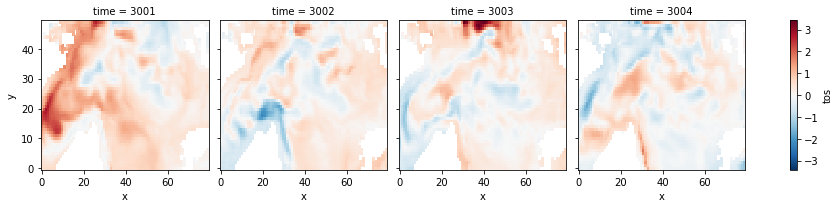

In [111]:
(control-control.mean('time')).isel(time=[1,2,3,4]).plot(col='time')

In [101]:
from climpred.relative_entropy import compute_relative_entropy, bootstrap_relative_entropy
from climpred.graphics import plot_relative_entropy

## perfect-model

In [102]:
neofs=ds.member.size-1

In [103]:
rel_ent = compute_relative_entropy(ds, control,nmember_control=100,neofs=neofs)

In [104]:
rel_ent.to_dataframe().unstack(0).head()

R                                       S                      \
init      3014      3061      3175      3237      3014      3061      3175   
lead                                                                         
1     2.650396  3.880845  8.779304  4.982448  0.167235  0.199782  0.104698   
2     2.596730  1.986024  2.033927  1.374404  0.111563  0.149119  0.787461   
3     4.399569  3.513452  4.650293  3.178682  0.446752  0.514517  2.056893   
4     2.170695  3.614986  3.659863  1.859126  0.402666  0.203317  0.310450   
5     3.239152  6.052140  4.174407  5.723797  0.509391  0.310923  0.131804   

                       D                                
init      3237      3014      3061      3175      3237  
lead                                                    
1     0.295870  2.483161  3.681063  8.674605  4.686578  
2     0.495083  2.485167  1.836905  1.246466  0.879321  
3     0.402120  3.952817  2.998935  2.593400  2.776562  
4     1.289309  1.768029  3.411669  3.349413  0.569818  
5     2.112031  2.729761  5.741216  4.042603  3.611766

In [105]:
rel_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=neofs,
                               nmember_control=100)

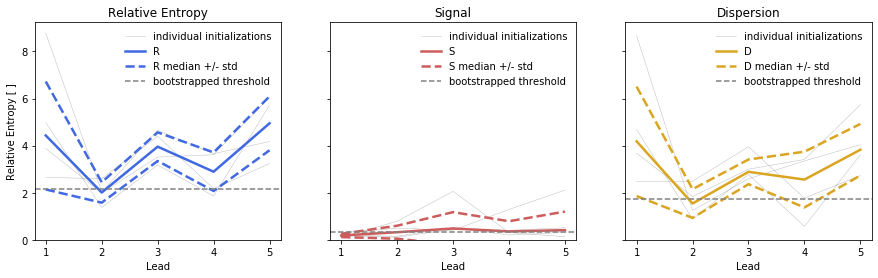

In [108]:
plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))
plt.show()

## DPLE, LENS
faking data with DPLE, LENS coords

In [136]:
control = control.isel(time=np.arange(0,65)%50)
control['time'] = np.arange(3000,3000+control.time.size)

In [137]:
def _shuffle(ds, dim='init'):
    """Shuffle ensemble members to uninitialize the data."""
    old_dim_range = ds[dim]
    shuffled = ds.sel({dim: np.random.permutation(ds[dim])})
    shuffled[dim] = old_dim_range
    shuffled = shuffled.sortby(dim)
    return shuffled

In [138]:
lens = xr.concat([_shuffle(control,'time') for _ in range(10)],dim='member').isel(time=slice(0,65))
lens['time']=np.arange(1950,2015)
lens['member']=np.arange(lens.member.size)
#lens

In [139]:
dple = xr.concat([lens.rename({'time':'init'})]*10,'lead')
dple['lead']=np.arange(1,1+dple.lead.size)
#dple

In [142]:
#compute_relative_entropy(dple, lens,nlead=4,nmember_control=5,neofs=3).to_dataframe().unstack(0).head()

In [143]:
#bootstrap_relative_entropy(dple, lens,nlead=4,nmember_control=5,neofs=3,bootstrap=15)

## Understand nmember_control
This implementation is experimental and seems unstable if a low number of control members is choosen to describe the base distribution.


 nmember_control = 5


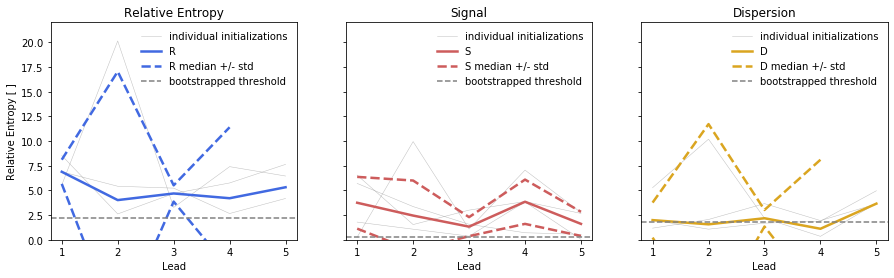


 nmember_control = 10


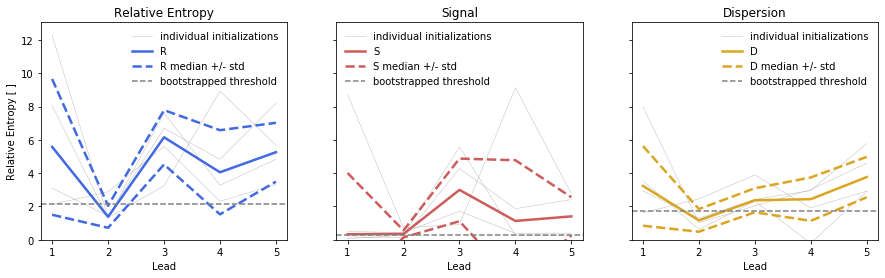


 nmember_control = 20


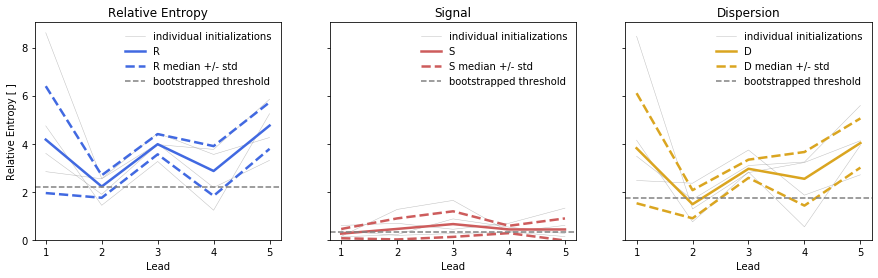


 nmember_control = 50


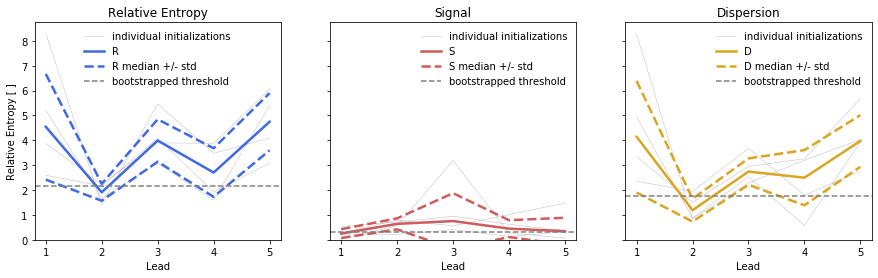


 nmember_control = 100


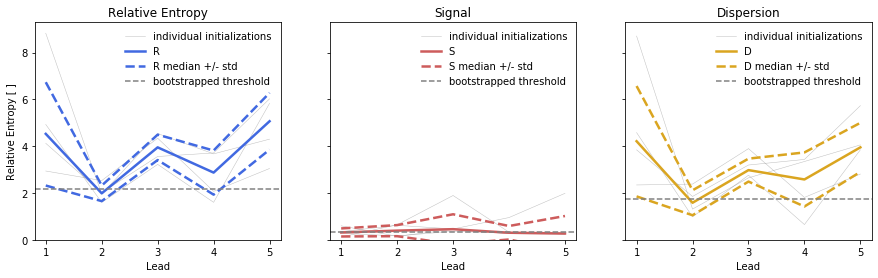

In [112]:
import matplotlib.pyplot as plt
for i in [5,10,20,50,100]:
    print('\n nmember_control =',i)
    rel_ent = compute_relative_entropy(ds, control,nmember_control=i,neofs=neofs)
    el_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=neofs,
                               nmember_control=i)
    plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))
    plt.show()